In [306]:
import pandas as pd
import geopy.distance

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


### Sedes y escuelas

In [97]:
sedes_loc = pd.read_csv('sedes_loc_clean.csv')
sedes_loc['coords_d'] = list(zip(sedes_loc.lat, sedes_loc.lng))

AMBA_lng = (sedes_loc['lng'] > -59.2) & (sedes_loc['lng'] <= -57.8)
AMBA_lat = (sedes_loc['lat'] < -34.05) & (sedes_loc['lat'] >= -35.1)

sedes_AMBA = sedes_loc.loc[AMBA_lng & AMBA_lat]

oferta_apde = pd.read_csv('./oferta_apde.csv')

oferta_estrat_AMBA = oferta_apde.loc[(oferta_apde['Ámbito'] == 'Público') & oferta_apde['Estrategica']].merge(sedes_AMBA, on = ['Universidad', 'Facultad', 'Domicilio'], how = 'left').dropna()


escuelas = pd.read_csv('esc_med_BUE_CABA.csv')
escuelas = escuelas.groupby(['cue', 'nombre_estab', 'lat', 'lng', 'municipio', 'Provincia', 'sector de gestión'])['Matricula est 5to'].sum().reset_index()

### Poligonos AMBA

In [ ]:
# Cargar localidades
import geopandas as gpd

localidades = gpd.read_file('./localidades/localidades.geojson')
barrios = gpd.read_file('./localidades/barrios_badata.shp').to_crs({'init': 'epsg:4326'}).rename({'WKT': 'geometry', 'BARRIO': 'Localidad'},axis = 1)

localidades = pd.concat([localidades0, barrios]).dropna(axis = 1).reset_index().rename({'index': 'index_l'}, axis = 1)
localidades['Centroid'] = [(P.y, P.x) for P in localidades['geometry'].centroid]

partidos = gpd.read_file('./localidades/partidos.shp')['geometry'].to_crs({'init': 'epsg:4326'})

import shapely

# ejido = gpd.read_file('./ejido.json')
AMBA_region = gpd.GeoSeries(shapely.geometry.Polygon([(-59.2,-35.1), (-57.8,-35.1), (-57.8,-34.05), (-59.2,-34.05)]))
rural_region = AMBA_region.difference(ejido['geometry'])

In [98]:
# mask_lng = (escuelas['lng'] > -58.55) & (escuelas['lng'] <= -58.45)
# mask_lat = (escuelas['lat'] < -34.5) & (escuelas['lat'] >= -34.6)
mask_lng = (escuelas['lng'] > -59.2) & (escuelas['lng'] <= -57.8)
mask_lat = (escuelas['lat'] < -34.05) & (escuelas['lat'] >= -35.1)

escuelas_mask = escuelas.loc[mask_lng & mask_lat]
escuelas_mask['coords_o'] = list(zip(escuelas_mask.lat, escuelas_mask.lng))


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [327]:
# # Compute distance matrix (to places)

# origenes = escuelas_mask[['coords_o']].reset_index()

# destinos = localidades[['Localidad', 'Centroid']].drop_duplicates()

# origenes['key'] = 0
# destinos['key'] = 0
# distances = pd.merge(origenes, destinos,on='key').set_index(['index', 'Localidad']).drop('key', axis = 1)

# # distances
# def f(x):    
#     return geopy.distance.vincenty(x['coords_o'], x['Centroid']).km

# distances['distance_km'] = distances.apply(f, axis=1)

# dist_places = distances.reset_index().pivot_table(values='distance_km', index='index', columns = 'Localidad')

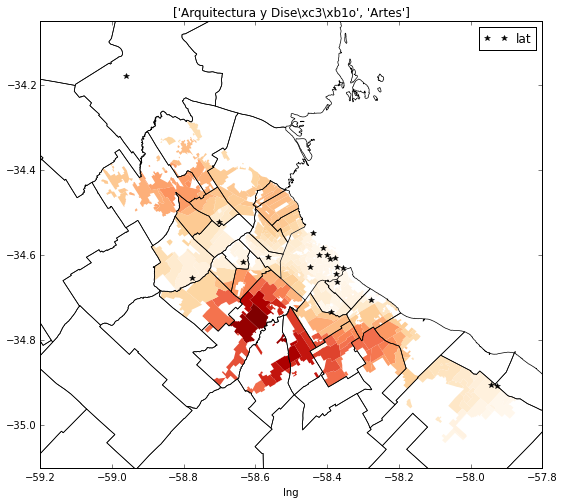

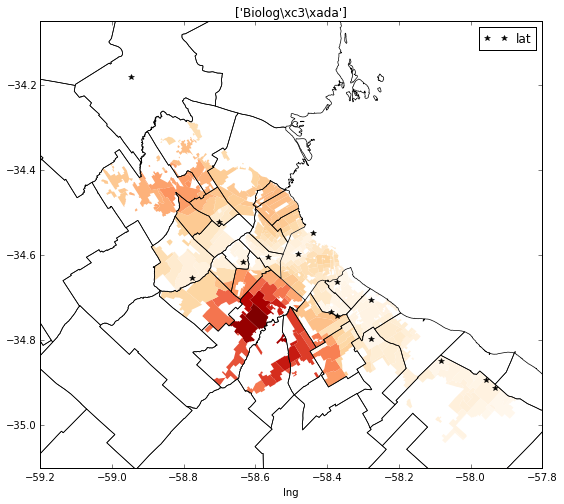

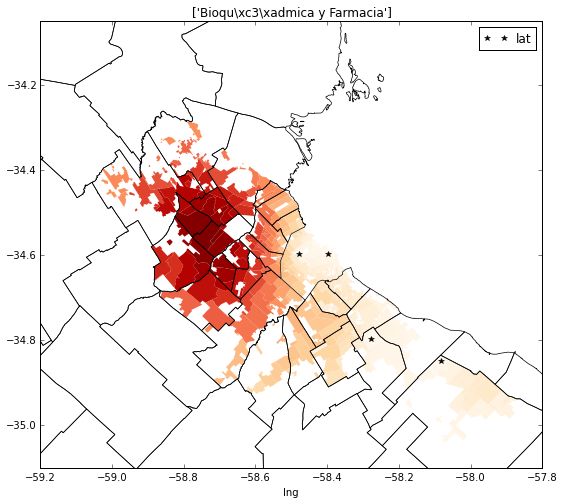

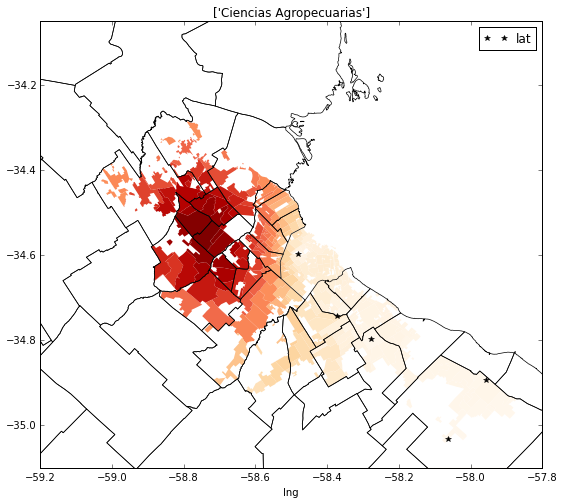

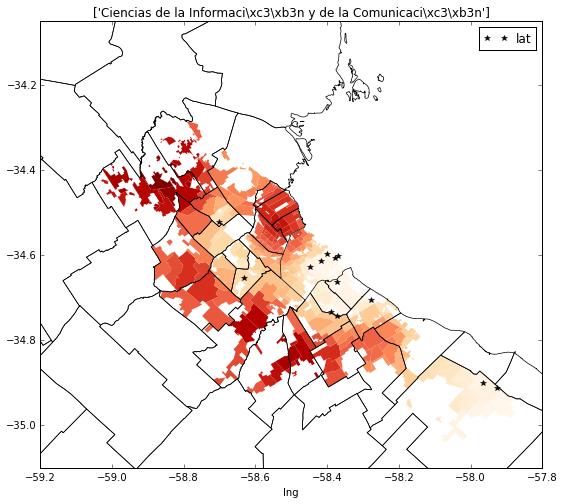

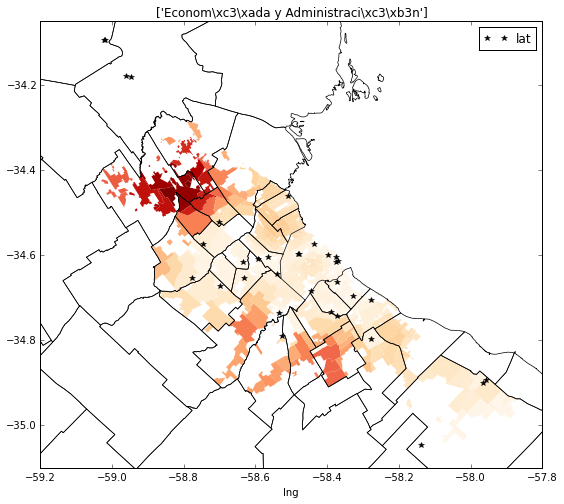

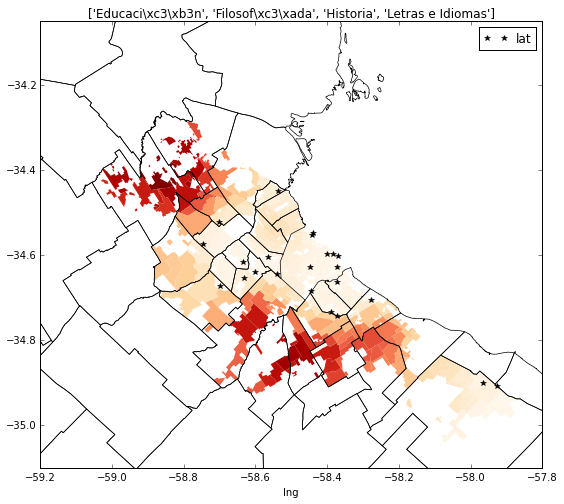

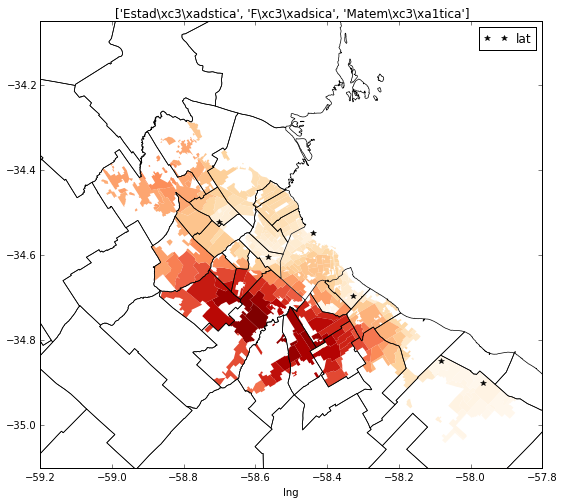

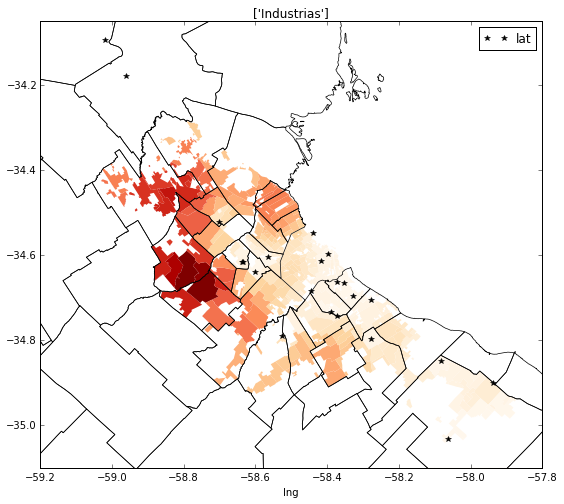

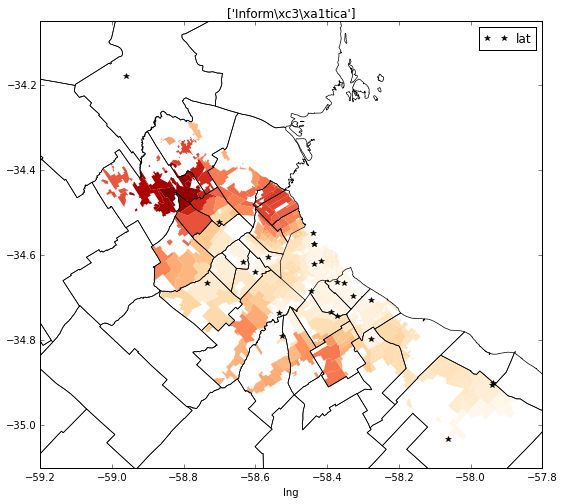

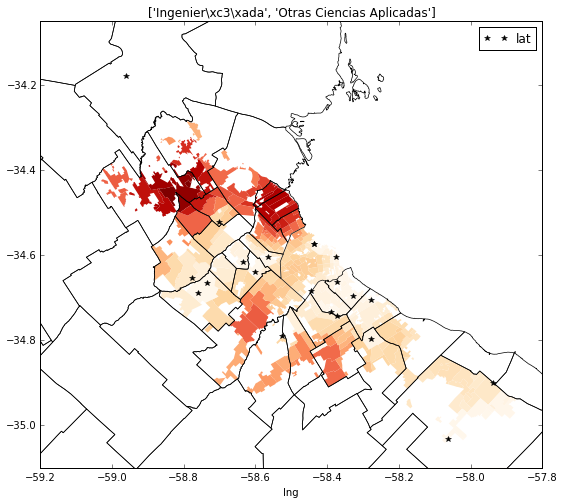

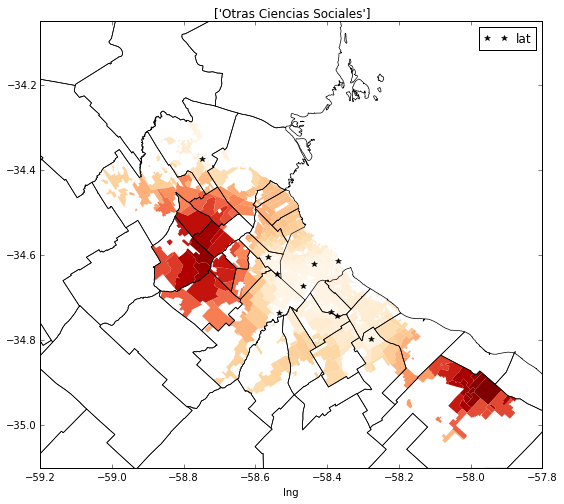

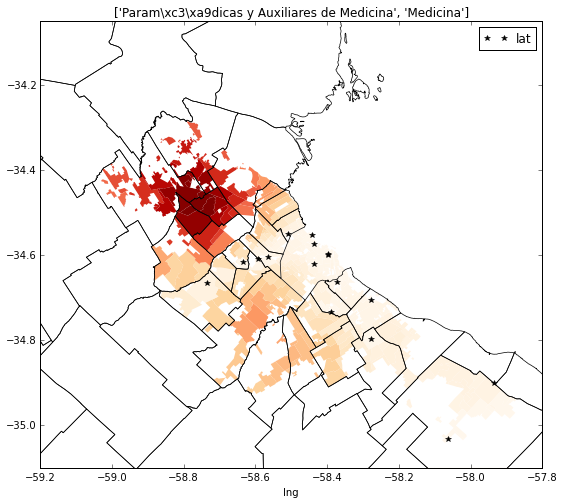

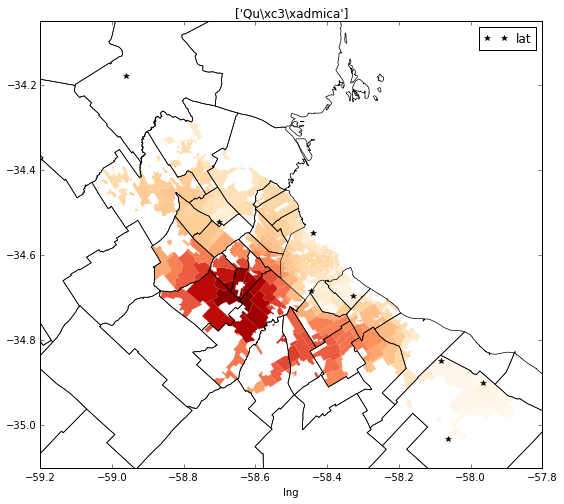

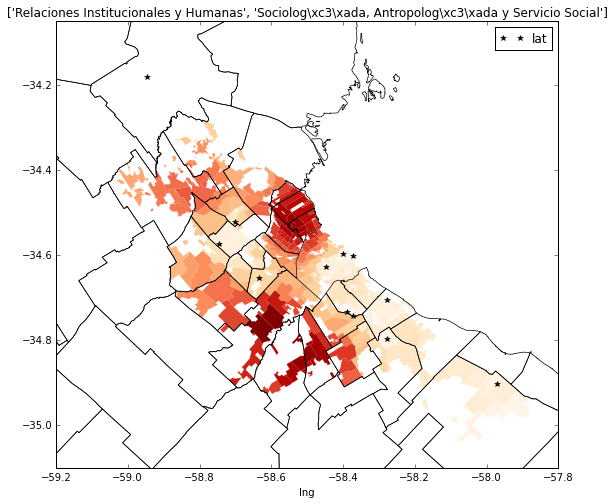

In [489]:
# Compute distance matrix (to universities)

origenes = escuelas_mask[['coords_o']].reset_index()

for temas in [['Arquitectura y Diseño', 'Artes'], ['Biología'], ['Bioquímica y Farmacia'],
              ['Ciencias Agropecuarias'], ['Ciencias de la Información y de la Comunicación'],
              ['Economía y Administración'], ['Educación', 'Filosofía', 'Historia', 'Letras e Idiomas'], 
              ['Estadística', 'Física', 'Matemática'], ['Industrias'], ['Informática'], 
              ['Ingeniería', 'Otras Ciencias Aplicadas'], ['Otras Ciencias Sociales'],
              ['Paramédicas y Auxiliares de Medicina', 'Medicina'], ['Química'], 
              ['Relaciones Institucionales y Humanas', 'Sociología, Antropología y Servicio Social']
             ]:
    
    
    destinos = oferta_estrat_AMBA.loc[oferta_estrat_AMBA.Disciplina.isin(temas)][['Universidad', 'Facultad', 'coords_d']].drop_duplicates()

    origenes['key'] = 0
    destinos['key'] = 0
    distances = pd.merge(origenes, destinos,on='key').set_index(['index','Universidad', 'Facultad']).drop('key', axis = 1)

    # distances
    def f(x):    
        return geopy.distance.vincenty(x['coords_o'], x['coords_d']).km

    distances['distance_km'] = distances.apply(f, axis=1)
    dist_disc = distances.unstack(0)['distance_km'].T

    result_disc = gpd.GeoDataFrame(-(dist_places.T - pd.DataFrame(dist_disc.min(axis = 1)).values.flatten()).T.clip(-np.inf, 0).multiply(escuelas['Matricula est 5to'], axis = 0).sum(), columns = ['dist_saved']).reset_index()
    result_disc = result_disc.merge(localidades[['Localidad', 'geometry']])

    fig, ax = plt.subplots(1, figsize = (9, 8))
    result_disc.plot(column='dist_saved', cmap='OrRd', linewidth = 0, ax = ax)
    facs_lat_lng = oferta_estrat_AMBA.loc[oferta_estrat_AMBA.Disciplina.isin(temas)][['lat', 'lng']].drop_duplicates()
    facs_lat_lng.plot(x = 'lng', y = 'lat', marker = '*', color = 'k',linewidth = 0, ax = ax)
    rural_region.plot(ax = ax, color = 'w', linewidth = 0)
    partidos.plot(ax = ax, facecolor="none", edgecolor='black', lw=0.7)
    ax.set_title(temas)
    ax.set_xlim(-59.2, -57.8)
    ax.set_ylim(-35.1, -34.05)

    plt.show()

In [77]:
distances['ranking'] = distances.reset_index().groupby("index")["distance_km"].rank().values
distances.loc[distances.ranking <= 3]

coords_o  \
index Universidad                             Facultad                                                           
0     Universidad Nacional de La Plata        Facultad de Ciencias Exactas             (-34.907574, -57.96381)   
                                              Facultad de Ingeniería                   (-34.907574, -57.96381)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata               (-34.907574, -57.96381)   
1     Universidad Nacional de La Plata        Facultad de Ciencias Exactas             (-34.907574, -57.96381)   
                                              Facultad de Ingeniería                   (-34.907574, -57.96381)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata               (-34.907574, -57.96381)   
2     Universidad Nacional de La Plata        Facultad de Ciencias Exactas            (-34.925977, -57.946744)   
                                              Facultad de Ingeniería                  (-34.925977, -57.946744)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata              (-34.925977, -57.946744)   
3     Universidad Nacional de La Plata        Facultad de Ciencias Exactas            (-34.925977, -57.946744)   
                                              Facultad de Ingeniería                  (-34.925977, -57.946744)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata              (-34.925977, -57.946744)   
4     Universidad Nacional de La Plata        Facultad de Ciencias Exactas            (-34.925977, -57.946744)   
                                              Facultad de Ingeniería                  (-34.925977, -57.946744)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata              (-34.925977, -57.946744)   
5     Universidad Nacional de La Plata        Facultad de Ciencias Exactas            (-34.953944, -57.972944)   
                                              Facultad de Ingeniería                  (-34.953944, -57.972944)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata              (-34.953944, -57.972944)   
6     Universidad Nacional de La Plata        Facultad de Ciencias Exactas            (-34.953944, -57.972944)   
                                              Facultad de Ingeniería                  (-34.953944, -57.972944)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata              (-34.953944, -57.972944)   
7     Universidad Nacional de La Plata        Facultad de Ciencias Exactas            (-34.869318, -58.048655)   
                                              Facultad de Ingeniería                  (-34.869318, -58.048655)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata              (-34.869318, -58.048655)   
8     Universidad Nacional de La Plata        Facultad de Ciencias Exactas            (-34.869318, -58.048655)   
                                              Facultad de Ingeniería                  (-34.869318, -58.048655)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata              (-34.869318, -58.048655)   
9     Universidad Nacional de La Plata        Facultad de Ciencias Exactas            (-34.892841, -57.962711)   
                                              Facultad de Ingeniería                  (-34.892841, -57.962711)   
      Universidad Tecnológica Nacional        Facultad Regional La Plata              (-34.892841, -57.962711)   
...                                                                                                        ...   
5325  Universidad de Buenos Aires             Facultad de Ingeniería          (-34.6498245708, -58.5112931101)   
      Universidad Nacional de Tres de Febrero Secretaría Académica            (-34.6498245708, -58.5112931101)   
      Universidad Tecnológica Nacional        Facultad Regional Buenos Aires  (-34.6498245708, -58.5112931101)  

In [71]:
distances_Industrias = distances
distances_Industrias.to_csv('dist_Ind.csv')